# Case Study 2

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [20]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [22]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

Selected Features: 18


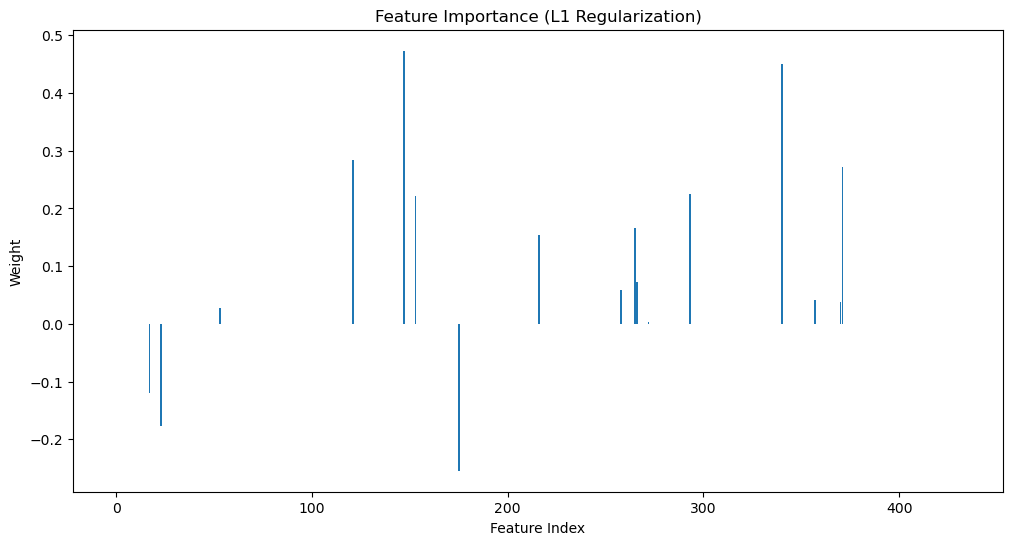

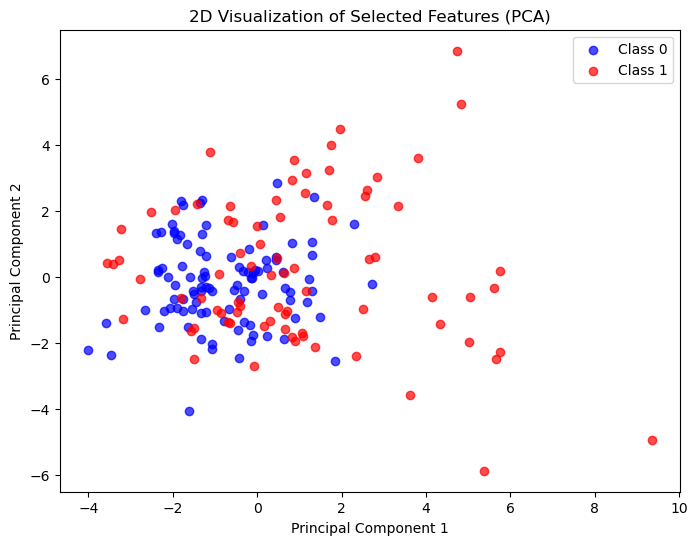


Classifier Performance with L1 Feature Selection:
  Classifier  Mean Accuracy  Std Dev Accuracy
0        SVM       0.877778          0.054433
1        KNN       0.888889          0.070273


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.1)
l1_model.fit(X_scaled, y)

sfm = SelectFromModel(l1_model, prefit=True)
X_selected = sfm.transform(X_scaled)
selected_features = X_selected.shape[1]
print(f"Selected Features: {selected_features}")

svm_model = SVC(kernel='linear', random_state=42)
svm_scores = cross_val_score(svm_model, X_selected, y, cv=10, scoring='accuracy')

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn_model, X_selected, y, cv=10, scoring='accuracy')

plt.figure(figsize=(12, 6))
plt.bar(range(len(l1_model.coef_[0])), l1_model.coef_[0])
plt.title("Feature Importance (L1 Regularization)")
plt.xlabel("Feature Index")
plt.ylabel("Weight")
plt.show()

if X_selected.shape[1] >= 2:  
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_selected)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label="Class 0", alpha=0.7, color='blue')
    plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label="Class 1", alpha=0.7, color='red')
    plt.title("2D Visualization of Selected Features (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

results = pd.DataFrame({
    "Classifier": ["SVM", "KNN"],
    "Mean Accuracy": [svm_scores.mean(), knn_scores.mean()],
    "Std Dev Accuracy": [svm_scores.std(), knn_scores.std()]
})


print("\nClassifier Performance with L1 Feature Selection:")
print(results)